## GD13. Face Detection

## 13-1. Dlib 얼굴 인식의 문제점
- 이미지 속의 얼굴을 빠르고 정확하게 인식하는 방법 중 Dlib 라이브러리를 이용해 Face Landmark를 찾아내는 것이 있음 -> 하지만 이것만으로는 충분하지 않았음. 
    - 얼굴을 잘 못 찾고
    - 동영상을 처리하기에 너무 느리고
    - 얼굴각도, 방향, 크기 등의 변화에 취약함 등의 문제가 있었음. 
- Face detection에서 많은 시간이 드는 요소는 **Sliding window**임. 따라서 이를 버려야 빨라짐 -> 2-stage 방식의 detection은 좋은 선택이 아님. 
- 또한 연산의 병렬화가 가능해야 함. 

## 13-2. Single Stage Object Detection
- 2-stage detector는 정확도는 높지만 실행속도(FPS)가 보통 느림. 물체가 존재하는 bouding box를 먼저 찾은(localization) 후에 bounding box를 분류하는 두 과정을 순차적으로 거쳤기 때문에, 속도라 느렸음. 
- 하지만 얼굴 인식과 같이 딥러닝 모델이 가벼워야 하는 task는 1-stage 기반을 사용하는 것이 유리함. 1-stage detector는 localization과 classification을 동시에 수행하기에 2-stage detector보다 속도가 빠르지만 정확도가 낮다는 단점이 있음. 
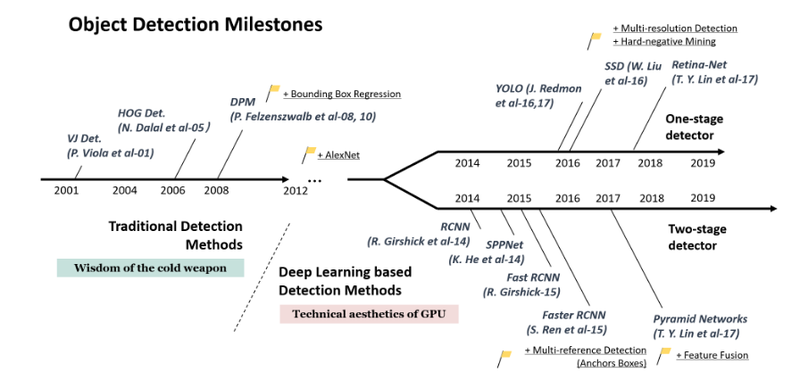

[Object Detection Milestones]
https://arxiv.org/pdf/1905.05055.pdf

## 13-3. YOLO (1) YOLO v1의 등장


### YOLO : You Only Look Once
- YOLO의 출현은 당시 전 세계 cv 학계와 업계에 충격적일 정도의 기술 진보를 보여줬음. 

## 13-4. YOLO (2) YOLO v1의 원리
- YOLO를 설명한 논문은 [You Only Look Once:Unified, Real-Time Object Detection](https://arxiv.org/pdf/1506.02640.pdf)임. 

### YOLO의 특징
1. You Only Look Once
    - 전체 이미지를 보는 횟수가 1회라는 것을 의미함.
    - YOLO는 클래스에 대한 정보와 주변 정보까지 한 번에 학습하고 처리함. 따라서 배경 오류가 적고 일반화 성능이 좋다고 함. 
2. Unified
    - Localization과 Classification을 동시에 수행함. YOLO는 이미지를 신경망에 넣어주기만 하면 바로 detection이 가능함. 
3. Real-Time
    - 기본적인 YOLO 모델로 45FPS, 빠른 버전은 150FPS까지 성능을 보임 -> 따라서 스트리밍 비디오에서도 실시간으로 객체를 detection 가능함. 
    - 그 외에도 Object Detection을 회귀 문제로 관점을 전환했고, 여러 도메인에서 object detection이 가능하다는 특징이 있음. 

### RCNN과 YOLO
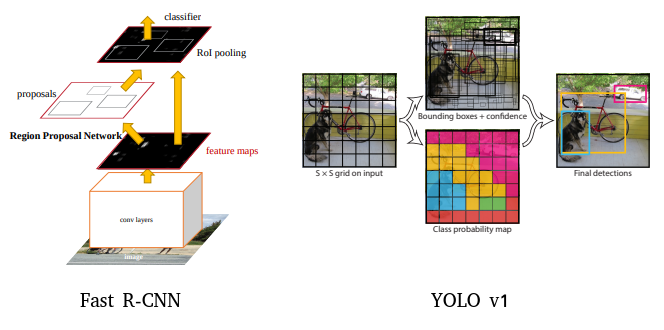

https://arxiv.org/pdf/1506.01497v3.pdf, https://arxiv.org/pdf/1506.02640.pdf


- 대표적인 2-stage detector인 RCNN과 1-stage detector인 YOLO 모델은 아래와 같이 기본 가정이 차이남. 
    - RCNN 계열의 가정 : 객체가 존재할 것 같은 곳을 backbone network로 표현할 수 있다 -> Region Proposal Network(RPN)
    - YOLO v1의 가정 : 이미지 내의 작은 영역을 나누면 그 곳에 객체가 있을 수 있음 -> grid 내에 객체가 존재함.

### YOLO의 grid cell
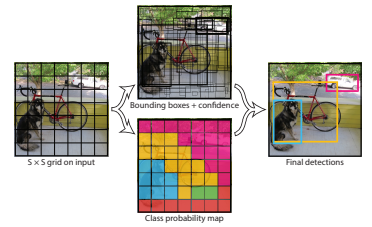

- YOLO는 이미지를 S x S grid로 나누고, box regression 단계와 각 클래스마다 probability map을 구하는 단계가 동시에 병렬적으로 수행됨. 
- 논문에서는 이미지를 7 x 7 grid로 나누고, 각 grid cell마다 예측하는 bouding box(bbox)를 2개, 총 클래스의 수는 20으로 정함. 
- 각 grid cell은 bounding box(bbox)와 C개의 class 확률을 예측함. 
- 각 bouding box(bbox, B)는 x, y, w, h, confidence score를 예측함. x, y는 bbox의 중심 좌표이고 w, h는 너비와 높이임. 주의할 점은 w, h는 입력 이미지를 bbox의 너비와 높이를 나눠서 normalize한 값으로, 0과 1 사이의 값을 가짐. 
- confidence score는 box가 객체를 포함하고 있는지를 모델이 얼마나 자신 있는지, 그리고 박스가 에측하는 것이 얼마나 정확한지를 보여줌. 이를 식으로 나타내면 아래와 같음. 
$$P(Object)∗IoU^{pred}_{truth}$$
- 만약 grid cell이 객체를 포함하지 않으면 $P(Object)$이 0이므로 confidence score는 0임. grid cell이 객체를 정확히 포함하고 있다면 $P(Object)$는 1이므로 결국 IoU만 남음 -> 따라서 confidence score가 예측된 box와 ground truth box 사이의 IoU와 같도록 하는 것이 좋음. 
​- C개의 조건부 클래스 확률 $(P(Class_i|Object)$은 grid cell이 사물을 포함할 때 bbox안의 객체가 i번째 클래스에 속할 확률임. bouding box의 개수와 상관 없이 각 grid cell의 확률만 예측함. 
- 위의 내용을 정리하면 하나의 grid cell에 대해 아래와 같은 tensor가 나옴. 
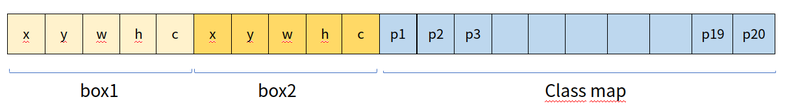

- 1개의 7x7 grid 당 2개의 bounding box(BBox)와 20개 클래스를 예측하는 YOLO를 만들고 싶은 경우, output tensor의 크기는 7 x 7 x (5 x 2 + 20)이며, 이를 flatten하면 1470임. 
- 위의 이미지를 보면 자전거를 포함하는 grid가 많음. 학습이 잘 된 경우는 해당 grid들이 모두 비슷한 크기로 자전거의 bbox를 잡음 -> 여기서 동일한 객체를 잡는 bbox가 많아진다는 문제가 생김. 
- 이 때는 **NMS(Non-Maximum Suppression)와 같은 기법을 이용함. object detector가 예측한 여러 개의 bounding box 중 정확한 bounding box만을 선택하는 기법임. 
    1. 하나의 클래스에 대한 높은 confidence score 순서대로 bbox를 정렬함. confidence score가 특정 threshold를 넘지 않는 것은 제거함. 
    2. 가장 높은 confidence score의 bbox와 겹치는 다른 bbox를 비교해 IoU가 threshold보다 높으면 겹치는 bbox를 목록에서 제거함 -> 같은 객체를 detect 하고 있는 것이기 때문
    3. 1과 2의 과정을 반복해 마지막으로 남은 bbox를 반환
    4. 각 클래스에 대해 위의 과정을 반복함. 

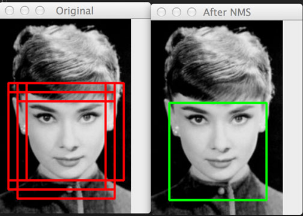

[NMS를 적용했을 때의 bounding box]
https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/

- YOLO의 목표는 grid에 포함된든 객체를 잘 잡아내는 것임 -> 1개 grid에 귀속된 bbox 정보(x, y, w, h)의 학습 목표는 bbox의 ground truth와 최대한 동일하도록 학습하는 것임. 학습이 제대로 이루어졌는지 확인하기위해 객체 인식 모델의 성능 평가 도구인 IoU를 사용함. 

### YOLO의 네트워크 구조

YOLO는 24개의 conv 레이어와 2개의 fc 레이어로 이루어짐. 
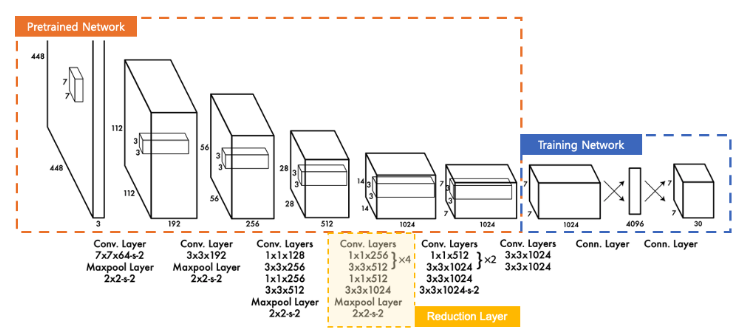

[YOLO Architecture]
https://medium.com/curg/you-only-look-once-%EB%8B%A4-%EB%8B%A8%EC%A7%80-%ED%95%9C-%EB%B2%88%EB%A7%8C-%EB%B3%B4%EC%95%98%EC%9D%84-%EB%BF%90%EC%9D%B4%EB%9D%BC%EA%B5%AC-bddc8e6238e2

- 모델 구조의 앞부분(Pretrained)은 ImageNet의 1000개 클래스 데이터셋을 갖고 사전학습한 GoogLeNet 모델임. 사전학습을 위해 20개의 Conv 레이어와 average pooling 레이어와 fc 레이어를 사용함. 그러나 GoogLeNet의 인셉션 모듈 대신 1x1 reduction 래이어를 사용해 연산량을 감소시켰다고 함. (무슨 말인지 잘 모르겠음)
- detection을 위해 사전학습된 모델에 4개의 Conv 레이어와 2개의 FC 레이어를 추가했고, PASCAL VOC 데이터셋으로 fine-tuning함. fine-grained 이미지를 얻기 위해 원래의 224x224 이미지의 2배인 448x448의 이미지를 사용했다고 함. 
- 마지막 레이어는 클래스 확률과 bbox 좌표를 학습하고 예측해 S x S x (B * 5 + C) 크기의 텐서로 예측값이 출력됨. 

### YOLO의 Inference 과정
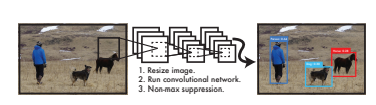

[The YOLO Detection System]
https://arxiv.org/pdf/1506.02640.pdf

- Inference를 할 때는 조건부 클래스 확률 $P(Class_i|Object)$를 각 box의 confidence 예측값과 곱해 각 box의 클래스별 confidence score를 얻을 수 있음. 각 score는 boxdㅢ 클래스의 확률과 예측된 box가 사물을 얼마나 잘 예측하는가를 보여줌. 
$$P(Class_i|Object) * P(Object) * IoU^{truth}_{pred} = P(Class_i) * IoU^{truth}_{pred}$$
- 이 과정을 모든 bbox에서 시행하면 한 이미지에서 예측한 클래스별 confidence score의 개수는 7*7*2 = 98개임. 98개의 클래스별 confidence score에 대해 20개의 클래스를 기준으로 NMS를 해 object에 대한 class와 bounding box location을 결정할 수 있음. 

## 13-5. YOLO (3) YOLO v1의 성능

### YOLO v1 의 loss 함수

- YOLO의 loss는 bbox의 위치 예측과 관련된 localization loss와 클래스 예측과 관련된 classification loss가 있으며, 두 loss 모두 SSE(sum-squared-error)에 기반함. 
- SSE는 두 loss를 동일하게 가중치를 주기 때문에, grid cell에 객체가 없을 경우 confidence score가 0에 가깝게 되어 모델의 불균형을 초래함. 
- 이를 해결하기 위해 bbox의 좌표에 대한 loss를 증가시키고, 객체가 없는 box의 confidence 예측값의 loss는 감소시킴 -> $λ_{coord}$, $λ_{noobj}$의 두 개의 하이퍼라라미터를 사용함. 
- 또한 SSE는 큰 bbox와 작은 bbox의 loss를 모두 동일한 가중치로 계산함 -> 작은 bbox가 작은 위치 변화에도 더 민감하기에 이를 개선하기 위해 bbox의 너비와 높이에 square root를 취함. 
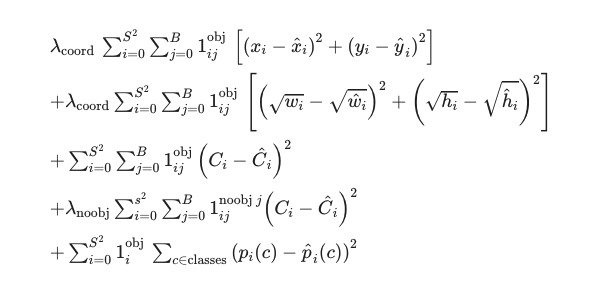

### YOLO의 성능
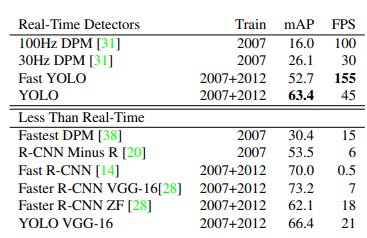

[Real-Time Systems on PASCAL VOC 2007]
https://arxiv.org/pdf/1506.02640.pdf


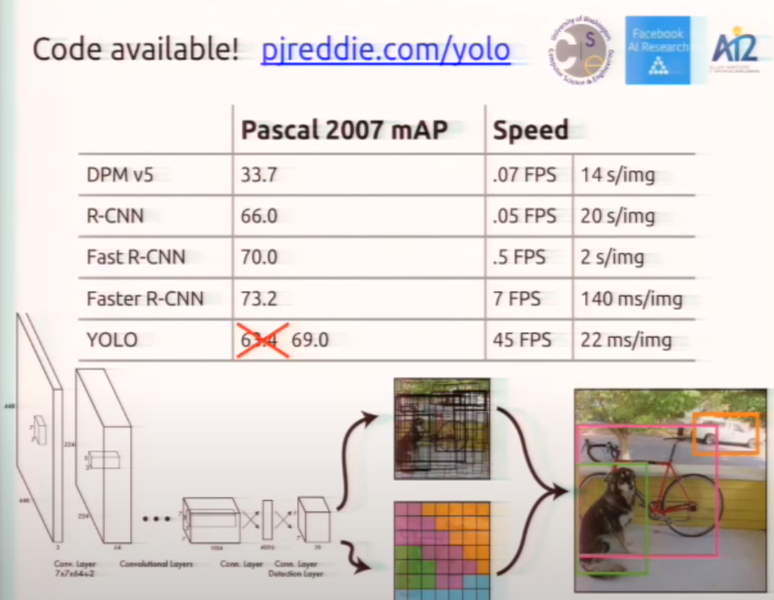

https://www.youtube.com/watch?v=NM6lrxy0bxs&t=142s


- YOLO v1은 Faster R-CNN과 성능에 큰 차이가 나지 않으면서 속도는 6배 이상인 혁신적인 연구였음. 

### YOLO v1의 단점

- 단점은 각각 grid cell이 2개의 box와 하나의 클래스만 예측 가능하기에 가까이에 있는 여러 객체를 예측하기 어려웠음. (새 떼와 같이 그룹으로 나타나는 작은 object에 대해 제대로 예측하지 못함)
- 또한 bbox의 형태가 training data를 통해 학습되었기 때문에 bbox 분산이 넓어 새로운 형태의 bbox 예측이 잘 안되었음 -> 모델 구조 상 backbone만 거친 feature map을 대상으로 bbox 정보를 예측하기 때문에 localization이 다소 부정확함. 
- loss 함수가 작은 bbox와 큰 bbox의 loss를 같게 다루기에 큰 box의 작은 loss보다 작은 box의 작은 loss가 IoU에 더 큰 영향을 미침 -> 2017년 YOLO v2가 나오게 됨!

## 13-6. YOLO (4) YOLO v2

### YOLO v2 의 목적

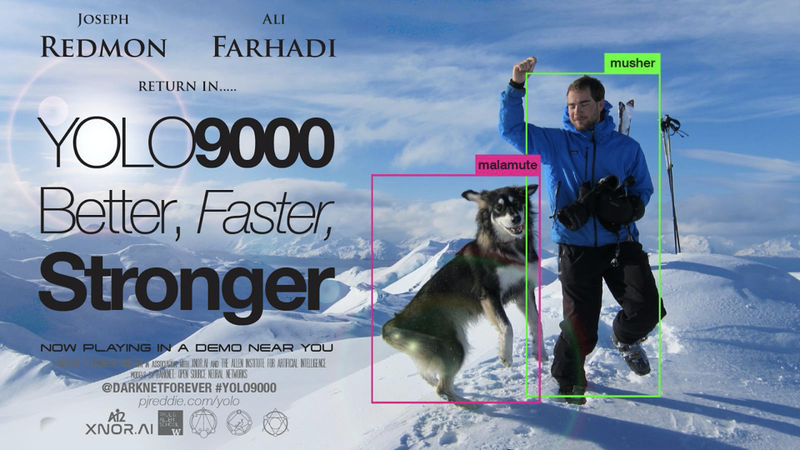

- Make it better
- Do it faster
- Makes us stronger
- 간단히 요약하자면 recall을 올리고 localization을 잘 해보자! 라고 함. 

### Make it better
- Better는 정확도를 올리기 위한 방법임. YOLO v2에서는 이전 모델에서 낮은 성능으로 보였던 localization과 recall을 높이면서 모델을 단순하게 만들고 속도도 빠르게 하려고 함.
- 이를 위해 아래와 같은 방법을 사용함. 
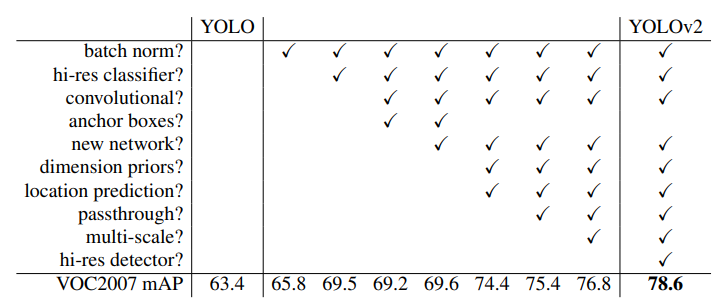

[A summary of results for design decisions]
https://openaccess.thecvf.com/content_cvpr_2017/papers/Redmon_YOLO9000_Better_Faster_CVPR_2017_paper.pdf

- Batch Normalizaton
    - 모든 conv 레이어에 batch normalization을 사용하고 dropout은 제거함. 
    - mAP에서 2% 이상의 성능 개선을 보임.
- High Resolution Classifier
    - YOLO v1에서 이미지넷의 224x224 이미지를 학습하고 detection에서 448x448 이미지를 사용했던 것과 다르게 처음부터 448x448 해상도로 학습함. 
    - mAP에서 4% 정도의 성능 개선을 이룸. 
- Convolutional with Anchor Boxes
    - bounding box를 예측하기 위해 YOLO v1의 fc 레이어를 제거한 후 Fully Convolutional Network를 사용했고, anchor box들을 사용해 bounding box를 예측함. 
    - 또한 1개의 중앙점을 갖는 13x13(홀수x홀수)의 출력 feature map을 만들도록 입력 이미지의 크기를 416x416으로 줄임. -> 대부분의 객체가 이미지의 중앙에 위치하기에 이 경우 중앙점이 하나일 경우에 더 잘 예측할 것이라는 기대 때문임. 
    - YOLO v2는 13x13x5개의 bounding box를 예측함. 
    - mAP는 약간 떨어지지만 recall은 81%에서 88%로 증가함. 
- Dimension Cluster
    - Fast R-CNN에서는 anchor box의 크기와 비율을 사전에 정해주고, 학습을 통해 세부 조정함. YOLO v2에서는 k-means clustering을 적용해 최적의 anchor box를 결정함. 
    - 유클리드 거리를 사용하는 일반적인 k-means clustering과 달리 IoU 개념을 distance metric으로 사용해 더 좋은 anchor box를 얻음 -> ground truth box와 유사한, IoU가 높은 anchor box를 찾기 위함임. 
    - 클러스터링 개수를 늘리면 정확도는 높아지지만 속도가 느려져 YOLO v2는 최종적으로 5개의 anchor box를 사용함. 

    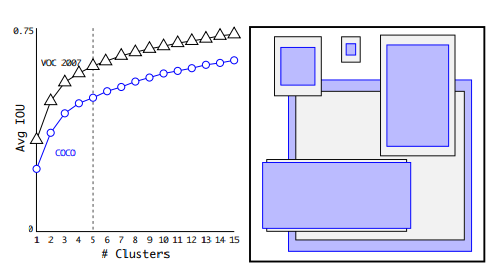

[Clustering box dimensions on VOC and COCO]
https://openaccess.thecvf.com/content_cvpr_2017/papers/Redmon_YOLO9000_Better_Faster_CVPR_2017_paper.pdf

- Direct location prediction
    - YOLO v2는 결정한 anchor box에 따라서 하나의 셀에서 5차원의 벡터로 이루어진 bounding box를 아래와 같은 방식으로 저정해 예측함. 학습 초반에 random initialization을 인한 학습의 불안정을 예방하기 위해 bounding box가 grid cell을 벗어나지 않도록 제약을 둠. YOLO v1dl grid cell의 중앙점을 예측한 것에 반해, YOLO v2는 좌상단으로부터 얼마나 이동했는지 예측함. 
    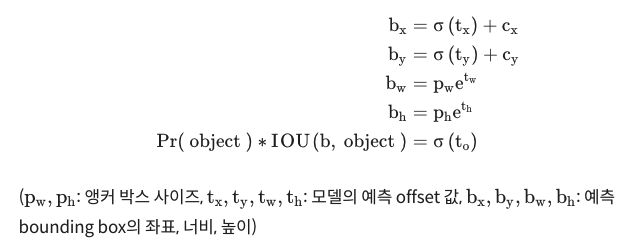
    - Dimension Cluster와 Direct location prediction을 사용해 약 5%의 성능 향상을 얻음.
    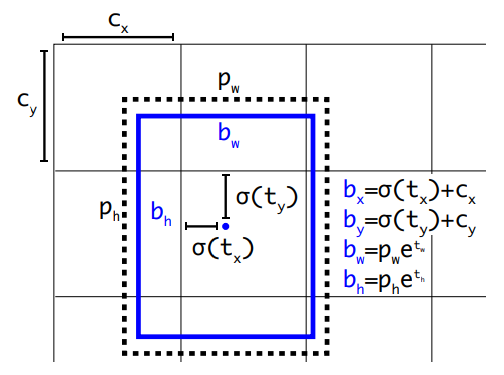 

[Bounding boxes with dimension priors and location prediction.]
https://openaccess.thecvf.com/content_cvpr_2017/papers/Redmon_YOLO9000_Better_Faster_CVPR_2017_paper.pdf

- Fine-Grained Features
    - 13x13의 feature map은 작은 물체 검출을 잘 하지 못한다는 단점이 있었기에 YOLO v2는 passingthrough 레이어라는 것을 사용함 -> 이전 레이어의 26x26 feature map과 13x13 feature map을 concatenate함 -> 26x26 feature map에 Fine-Grained Features(고해상도 피처)가 담겨 있기 때문임. 
    - 두 feature map의 크기가 다르기 때문에 26x26x512 feature map을 13x13x2048 feature map으로 변환한 후 concatenate함 -> 이로써 약 1%의 성능 향상을 보임. 
- Multi-Scale Training
    - 모델이 다양한 입력 사이즈에도 예측을 잘 할 수 있도록 매 10개의 batch마다 입력 이미지의 크기를 바꿔가면서 모델을 학습함. 모델이 32 간격으로 downsample되기에 입력 이미지는 32의 배수가 될 수 있음 -> 따라서 입력 이미지의 크기는 {320, 352, ... , 608} 중 하나가 사용됨. 

### Do it faster
- faster는 detection 속도를 향상시키기 위한 방법임. 
- Darknet-19
    - YOLO v2에서는 fc 레이어를 제거하고, global average pooling을 해 가중치 파라미터 수를 크게 줄임. 이렇게 만든 최종 모델을 Darknet-19라 부르는데, 19개의 conv 에이어와 5개의 maxpooling 레이어로 이루어짐. 